# LQRによる経路追従（諦め）

**TODO: ちゃんとしたモデルを書くのがだるすぎて諦めちゃった．また今度やる．**

参考：
* [RL vs Optimal Control: LQR for Trajectory Tracking (With Python Code)](https://kowshikchilamkurthy.medium.com/rl-vs-optimal-control-lqr-for-trajectory-tracking-with-python-code-105ce44e1761)
* [Path tracking simulation with LQR steering control and PID speed control](https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathTracking/lqr_steer_control/lqr_steer_control.py)

LQRは自動運転における経路追従などに使われています（多分．TODO: 参考文献）．
動く図があると楽しいので，LQRによる経路追従をやってみましょう．

次のモデルを考えます．

* 状態（３次元）：
    * $x, y, \gamma$：xの位置，yの位置，車が向いている角度
* 制御（２次元）：
    * $v, \omega$：車の速度，車の角速度


今回のコストは
$$
Q = \left[\begin{array}{lll}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0
\end{array}\right], \;
R = \left[\begin{array}{ll}
1 & 0 \\
0 & 1 \\
\end{array}\right]
$$

として，目標座標を$x^*, y^*$とすると，

$$
\min \mathbb{E}\left[(x_H-x^*)^{\top} Q (x_H-x^*)+\sum_{t=0}^{H-1}\left((x_t-x^*)^\top Q (x_t-x^*)+u_t^{\top} R u_t\right)\right]
$$

になります．

状態についての遷移を普通にモデル化すると
$$
\left[\begin{array}{l}
x_t \\
y_t \\
\gamma_t
\end{array}\right]=\left[\begin{array}{lll}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{array}\right]\left[\begin{array}{l}
x_{t-1} \\
y_{t-1} \\
\gamma_{t-1}
\end{array}\right]+\left[\begin{array}{cc}
\cos \gamma_{t-1} * d t & 0 \\
\sin \gamma_{t-1} * d t & 0 \\
0 & d t
\end{array}\right]\left[\begin{array}{c}
v_{t-1} \\
\omega_{t-1}
\end{array}\right]
$$
ですが，これだと制御できない状況が存在します．
例えば$\gamma_0=0$とすると，$\gamma=0$では右にしか移動できないと思い込み，$\omega$を変更しようとしません．するとそれ以降も$\omega$を変更しようとしないので，このモデルでLQRをするとずっと直進します．

変わりに，[LQRで経路追従](https://qiita.com/renhoge/items/58aa3e96ea76d1ed2515)みたいに極座標表記します．

$$
\left[\begin{array}{c}
e_t\\
\theta_t
\end{array}\right]=\left[\begin{array}{ll}
1 & 0  \\
0 & 1 
\end{array}\right]\left[\begin{array}{c}
e_{t-1}\\
\theta_{t-1}
\end{array}\right]+\left[\begin{array}{cc}
d t & 0 \\
0 & d t
\end{array}\right]\left[\begin{array}{c}
v_{t-1} \\
\omega_{t-1}
\end{array}\right]
$$

In [90]:
import numpy as np
from dataclasses import dataclass
import math

# ステップ幅
dt = 0.1  # time tick[s]


@dataclass
class State:
    x: float
    y: float
    yaw: float


def update_state(state: State, v: float, w: float):
    state.x = state.x + v * math.cos(state.yaw) * dt
    state.y = state.y + v * math.sin(state.yaw) * dt
    state.yaw = state.yaw + w * dt
    return state


In [102]:
import jax
import jax.numpy as jnp


LQR_H = 10  # receding horizonです．

A = jnp.eye(3)
Q = jnp.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]])
R = jnp.eye(2) * 0.1


def find_nearest_goal(xys, state):
    error = xys - np.array([state.x, state.y]).reshape(1, 2)
    nearest_idx = np.argmin((error ** 2).sum(axis=-1))
    if nearest_idx == len(xys) - 1 :
        return xys[-1]
    else:
        return xys[nearest_idx:nearest_idx+LQR_H][-1]


def compute_B(state: State):
    return jnp.array([
        [-jnp.cos(state.yaw) * dt, 0],
        [-jnp.sin(state.yaw) * dt, 0],
        [0, -dt],
    ])


@jax.jit
def compute_control(A, B, Q, R):
    d, _ = A.shape
    _, k = B.shape

    def backup(i, args):
        P, K = args
        h = LQR_H - i - 1

        # まずPを計算します
        P_h1 = P[h+1]
        P_h = A.T @ P_h1 @ A 
        P_h = P_h + Q
        P_h = P_h - A.T @ P_h1 @ B @ jnp.linalg.inv(B.T @ P_h1 @ B + R) @ B.T @ P_h1 @ A
        P = P.at[h].set(P_h)

        # 続いてゲインを計算します
        K_h = jnp.linalg.inv(B.T @ P_h1 @ B + R) @ B.T @ P_h1 @ A
        K = K.at[h].set(K_h)
        return P, K
    
    P = jnp.zeros((LQR_H+1, d, d))
    K = jnp.zeros((LQR_H, k, d))
    P = P.at[LQR_H].set(Q)
    args = P, K
    _, K = jax.lax.fori_loop(0, LQR_H, backup, args)
    return K



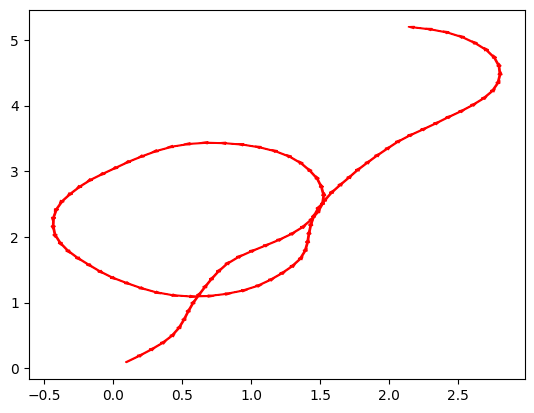

In [103]:
import matplotlib.pyplot as plt

# 追従すべきTrajectoryを生成します．
state = State(0.0, 0.0, np.pi / 4)
u = np.array([1.3, 0.0])  # 速度は固定します

xys = []

for h in range(100):
    xys.append((state.x, state.y))  # 追従すべきTrajectoryを集めておきます

    # 角速度だけ変えたTrajectoryです
    u[1] = np.clip(u[1] + np.random.uniform(-1, 1, 1), -2.0, 2.0)

    state = update_state(state, u[0], u[1])
    x, y = state.x, state.y
    dx = u[0] * math.cos(state.yaw) * dt
    dy = u[0] * math.sin(state.yaw) * dt
    plt.arrow(x, y, dx, dy, color="red", width=0.01)

xys = np.array(xys)

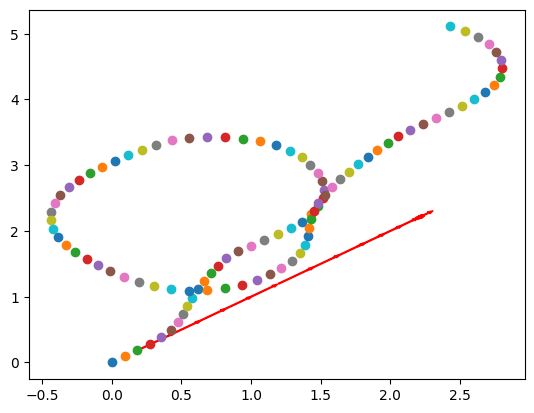

In [104]:
import matplotlib.pyplot as plt

# 追従すべきTrajectoryを生成します．
state = State(0.0, 0.0, np.pi / 4)


for h in range(100):
    B = compute_B(state)
    K = compute_control(A, B, Q, R)
    goal = find_nearest_goal(xys, state)
    xyyaw0 = np.array([goal[0] - state.x, goal[1] - state.y, -state.yaw])
    u = - K[0] @ xyyaw0

    state = update_state(state, u[0], u[1])
    x, y = state.x, state.y
    dx = u[0] * math.cos(state.yaw) * dt
    dy = u[0] * math.sin(state.yaw) * dt
    plt.arrow(x, y, dx, dy, color="red", width=0.01)

    plt.scatter(xys[h][0], xys[h][1])